# Imports

In [1]:
from model_builder import ModelBuilder
import random
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
plt.rcParams["font.family"] = "Times New Roman"
import warnings
warnings.filterwarnings("ignore")

In [2]:
with open("config.json", "rb") as json_file:
    config = json.load(json_file)
config

{'becker': {'filename': 'beckerestimation_output_conversation_level.csv',
  'cols_to_ignore': ['conversation_num',
   'mean_pre_discussion_error',
   'mean_post_discussion_error',
   'mean_pre_discussion_error_pct',
   'mean_post_discussion_error_pct',
   'question',
   'chatrooms',
   'trial_indx']},
 'csop': {'filename': 'csop_output_conversation_level.csv',
  'cols_to_ignore': ['conversation_num',
   'batch_num',
   'round_num',
   'round_index',
   'task_index',
   'complexity',
   'type',
   'social_perceptiveness',
   'skill',
   'normalized_score',
   'zscore_score',
   'zscore_round_duration',
   'zscore_efficiency']},
 'csopII': {'filename': 'csopII_output_conversation_level.csv',
  'cols_to_ignore': ['conversation_num',
   'batch_num',
   'vis_img',
   'int_verb',
   'ort_img',
   'rep_man',
   'soc_pers',
   'team_size',
   'difficulty',
   'score',
   'duration',
   'efficiency',
   'timestamp']},
 'dat': {'filename': 'DAT_output_conversation_level.csv',
  'cols_to_ignore':

# Repeated k-Fold Cross Validation
For each model, fit it k (=10) times, and track all metrics, as well as interpretability, across all the repeats.
This gets us a less noisy estimate at our models' performance.

In [3]:
def repeated_kfold_cv(model, k = 10, seed = 19104):

    """
    Parameters:
    - model: The model we are doing k-fold CV for
    - k: the number of fols (defaults to 10)
    - seed: the random seed (defaults to 19104)

    @returns the following, pouplated with data from the k0=-fold CV:
    - train_metrics: a dataframe to store all the training metrics
    - test_metrics: a dataframe to store all the test set metrics (we will universally use a 80-20 train-test split)
    - shap_df: a dataframe to store the Shapley value summaries for each fold
    - shap_correlation_df: a dataframe to store how the Shapley values correlate with feature values for each fold
    """

    # Repeated k-fold cross-validation
    random.seed(seed) # set seed for reproducibility
    random_states_list = [random.randint(100, 1000000) for _ in range(k)] # create a bunch of different random states

    # Store metrics --- R^2, MAE, MSE
    metrics = ['r2', 'mae', 'mse', 'rmse']
    train_metrics = pd.DataFrame(columns=metrics)
    test_metrics = pd.DataFrame(columns=metrics)

    for i in range(len(random_states_list)):
        # store the model metrics for each iteration
        metrics = model.evaluate_model(model.baseline_model, val_size = 0.2, test_size = None, random_state = random_states_list[i], visualize_model = False)
        train_metrics = train_metrics.append(metrics['train'], ignore_index=True)
        test_metrics = test_metrics.append(metrics['val'], ignore_index=True)
    
        # store the shap summary for each iteration

        try:     
            shap_summary = model.shap_summary
            shap_df = pd.merge(shap_df, shap_summary[['feature', 'shap']], on='feature')
            shap_df.rename(columns={'shap': f'shap_{i+1}'}, inplace=True)
            shap_correlation_df = pd.merge(shap_correlation_df, shap_summary[['feature', 'correlation_btw_shap_and_feature_value']], on='feature')
            shap_correlation_df.rename(columns={'correlation_btw_shap_and_feature_value': f'cor_{i+1}'}, inplace=True)
        except NameError:
            # we haven't defined these yet; we're in the first iteration!
            # we have to do this becaus model.X does not show up until after the first case when evaluate_model is called
            shap_df = pd.DataFrame({'feature': model.X.columns})
            shap_correlation_df = pd.DataFrame({'feature': model.X.columns})

            shap_summary = model.shap_summary
            shap_df = pd.merge(shap_df, shap_summary[['feature', 'shap']], on='feature')
            shap_df.rename(columns={'shap': f'shap_{i+1}'}, inplace=True)
            shap_correlation_df = pd.merge(shap_correlation_df, shap_summary[['feature', 'correlation_btw_shap_and_feature_value']], on='feature')
            shap_correlation_df.rename(columns={'correlation_btw_shap_and_feature_value': f'cor_{i+1}'}, inplace=True)


    shap_df.set_index('feature', inplace=True)
    shap_correlation_df.set_index('feature', inplace=True)

    return(shap_df, shap_correlation_df, train_metrics, test_metrics)

In [4]:
def get_repeated_kfold_cv_summary(shap_df, shap_correlation_df, train_metrics, test_metrics):
    """
    Get the means of the repeated k-fold cross validation across all relevant metrics.
    """
    shap_means = shap_df.mean(axis=1).sort_values(ascending = False)
    shap_cor_means = shap_correlation_df.mean(axis=1).reindex(index = shap_means.index)
    train_means = train_metrics.mean()
    test_means = test_metrics.mean()

    return(shap_means, shap_cor_means, train_means, test_means)

In [5]:
time_points = ["25% of data", "50% of data", "75% of data", "100% of data"]

In [49]:
NUM_TOP_FEATURES = 3

In [62]:
def plot_important_features_over_time(merged_df, title = "Top Feature Importance Over Time", filename="./figures/feature_importance.png"):
    # Transpose the DataFrame and sort by each time point
    top_features = merged_df.apply(lambda x: x.nlargest(NUM_TOP_FEATURES))

    non_na_feature = top_features.dropna()
    na_feature = top_features.loc[~top_features.index.isin(top_features.dropna().index)].fillna(0)

    # Plot a line chart to show how the top feature values change over time
    if(not non_na_feature.empty):
        ax = non_na_feature.T.plot(kind='line', marker='o', cmap=mpl.cm.Set2, linewidth=3)
        na_feature.T.plot(kind='line', marker='o', linestyle='--', cmap=mpl.cm.Dark2, linewidth=3, ax=ax)  # Use the same axis for dashed lines
    else:
        ax = na_feature.T.plot(kind='line', marker='o', linestyle='--', cmap=mpl.cm.Dark2, linewidth=3)
    
    plt.ylabel('Importance (SHAP value)', size=14)
    plt.title(title, fontsize=18, fontweight="bold")
    plt.xticks(range(len(time_points)), time_points, fontsize=14)
    plt.legend(loc='upper left', fontsize=12, bbox_to_anchor=(1.05, 1), bbox_transform=ax.transAxes)

    plt.savefig(filename, dpi=1200, bbox_inches='tight')
    plt.show()

In [7]:
def plot_r2_and_mse_over_time(metrics, title):
    # Transpose the data for plotting
    transposed_data = metrics.T
    fig, ax1 = plt.subplots()

    plt.style.use({"figure.facecolor": "white", "axes.facecolor": "white"})

    # Create the left y-axis for R^2
    ax1.set_ylabel("R^2", fontsize=14)
    ax1.plot(time_points, transposed_data["r2"], label="R^2", color="cadetblue", marker="o", linewidth=3)
    ax1.tick_params(axis="y", size=14)

    # Create the right y-axis for MSE
    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
    ax2.set_ylabel("MSE", fontsize=14)
    ax2.plot(time_points, transposed_data["mse"], label="MSE", color="mediumorchid", marker="o", linewidth=3)
    ax2.tick_params(axis="y", size=14)

    #x-axis font size
    ax1.tick_params(axis="x", labelsize=14)

    # Combine the legends for both lines
    lines, labels = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax2.legend(lines + lines2, labels + labels2, loc="upper left")

    # Adjust layout
    plt.title(title, fontweight="bold", fontsize=18)
    plt.tight_layout()
    plt.show()

# Per-Task Baseline Models
This notebook contains the _baseline models_ for each task. This allows us to get a quick understanding of the predictive features for each task (separately).

The lists of models are:

(1) Random Forests for each task:
- Jury
- CSOP Blended (across two datasets)
- CSOP Train -> CSOP II split
- DAT
- Estimation (Becker + Gurcay datasets, blended)

(2) Early Cut-off Models (Train model only on the first X% of the messages, so that we avoid issues where the final stages of the discussion reveal the outcome)
- 25% (all datasets)
- 50% (all datasets)
- 75% (all datasets)


# Jury

### Full Data (100)%

In [8]:
# Define the basic model
juries_model = ModelBuilder(dataset_names = ["juries"])
juries_model.select_target(target=["majority_pct"])
juries_model.define_model(model_type = 'rf')

In [9]:
# Call the Repeated k-Fold CV
jury_shap, jury_shap_cor, jury_train_metrics, jury_test_metrics = repeated_kfold_cv(juries_model)
jury_shap_means, jury_shap_cor_means, jury_train_means, jury_test_means = get_repeated_kfold_cv_summary(jury_shap, jury_shap_cor, jury_train_metrics, jury_test_metrics)

Checking Holdout Sets...Creating Holdout Sets...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Done
Training Model...Done


### 75% Data

In [10]:
juries_model75 = ModelBuilder(dataset_names = ["juries"], output_dir = '../output/first_75/')
juries_model75.select_target(target=["majority_pct"])
juries_model75.define_model(model_type = 'rf')

In [11]:
jury_shap75, jury_shap_cor75, jury_train_metrics75, jury_test_metrics75 = repeated_kfold_cv(juries_model75)
jury_shap_means75, jury_shap_cor_means75, jury_train_means75, jury_test_means75 = get_repeated_kfold_cv_summary(jury_shap75, jury_shap_cor75, jury_train_metrics75, jury_test_metrics75)

Checking Holdout Sets...Creating Holdout Sets...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Done
Training Model...Done


### 50% Data

In [12]:
juries_model50 = ModelBuilder(dataset_names = ["juries"], output_dir = '../output/first_50/')
juries_model50.select_target(target=["majority_pct"])
juries_model50.define_model(model_type = 'rf')

In [13]:
jury_shap50, jury_shap_cor50, jury_train_metrics50, jury_test_metrics50 = repeated_kfold_cv(juries_model50)
jury_shap_means50, jury_shap_cor_means50, jury_train_means50, jury_test_means50 = get_repeated_kfold_cv_summary(jury_shap50, jury_shap_cor50, jury_train_metrics50, jury_test_metrics50)

Checking Holdout Sets...Creating Holdout Sets...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Done
Training Model...Done


### 25% of Data

In [14]:
juries_model25 = ModelBuilder(dataset_names = ["juries"], output_dir = '../output/first_25/')
juries_model25.select_target(target=["majority_pct"])
juries_model25.define_model(model_type = 'rf')

In [15]:
jury_shap25, jury_shap_cor25, jury_train_metrics25, jury_test_metrics25 = repeated_kfold_cv(juries_model25)
jury_shap_means25, jury_shap_cor_means25, jury_train_means25, jury_test_means25 = get_repeated_kfold_cv_summary(jury_shap25, jury_shap_cor25, jury_train_metrics25, jury_test_metrics25)

Checking Holdout Sets...Creating Holdout Sets...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Done
Training Model...Done


### Combine Results for Juries

In [16]:
pd.concat([jury_shap_cor_means25, jury_shap_cor_means50, jury_shap_cor_means75, jury_shap_cor_means], keys = time_points, axis=1).head(10)

,25% of data,50% of data,75% of data,100% of data
feature,,,,
average_dale_chall_score,-0.666630,-0.570780,-0.808547,-0.705056
stdev_past_tense,-0.810860,-0.669051,-0.589480,-0.394227
min_info_exchange_zscore_conversation,0.824070,0.691094,0.684020,0.220805
average_negation,-0.701350,-0.292172,-0.166786,-0.418535
discursive_diversity,-0.671805,-0.461602,0.406375,-0.660073
min_positivity_zscore_chats,0.656874,0.676483,0.745118,0.769061
min_positive_bert,0.235569,0.252856,0.356273,0.463643
average_textblob_subjectivity,-0.354531,-0.510447,-0.389968,-0.012738
max_dale_chall_score,-0.552774,-0.371578,-0.766554,-0.192397


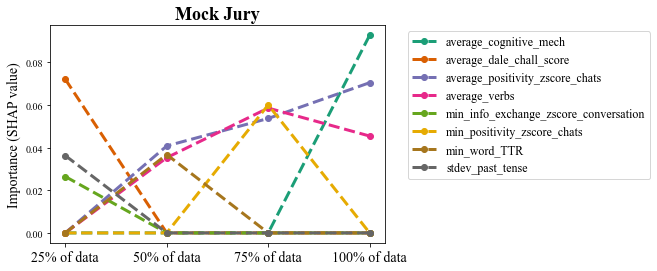

In [63]:
merged_df = pd.concat([jury_shap_means25, jury_shap_means50, jury_shap_means75, jury_shap_means], keys = time_points, axis=1)
plot_important_features_over_time(merged_df, "Mock Jury", "./figures/jury_features.svg")

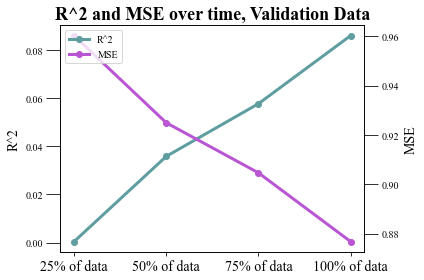

In [18]:
test_metrics = pd.concat([jury_test_means25, jury_test_means50, jury_test_means75, jury_test_means], keys = time_points, axis=1)
plot_r2_and_mse_over_time(test_metrics, "R^2 and MSE over time, Validation Data")

# CSOP (blended)

### Full Data (100%)

In [19]:
csop_blended_model = ModelBuilder(dataset_names = ["csop", "csopII"])
csop_blended_model.select_target(target=["zscore_efficiency", "efficiency"])
csop_blended_model.define_model(model_type = 'rf')

In [20]:
csop_shap, csop_shap_cor, csop_train_metrics, csop_test_metrics = repeated_kfold_cv(csop_blended_model)
csop_shap_means, csop_shap_cor_means, csop_train_means, csop_test_means = get_repeated_kfold_cv_summary(csop_shap, csop_shap_cor, csop_train_metrics, csop_test_metrics)

Checking Holdout Sets...Creating Holdout Sets...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Done
Training Model...Done


### 75% Data

In [21]:
csop_blended_model75 = ModelBuilder(dataset_names = ["csop", "csopII"], output_dir = '../output/first_75/')
csop_blended_model75.select_target(target=["zscore_efficiency", "efficiency"])
csop_blended_model75.define_model(model_type = 'rf')

In [22]:
csop_shap75, csop_shap_cor75, csop_train_metrics75, csop_test_metrics75 = repeated_kfold_cv(csop_blended_model75)
csop_shap_means75, csop_shap_cor_means75, csop_train_means75, csop_test_means75 = get_repeated_kfold_cv_summary(csop_shap75, csop_shap_cor75, csop_train_metrics75, csop_test_metrics75)

Checking Holdout Sets...Creating Holdout Sets...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Done
Training Model...Done


### 50% Data

In [23]:
csop_blended_model50 = ModelBuilder(dataset_names = ["csop", "csopII"], output_dir = '../output/first_50/')
csop_blended_model50.select_target(target=["zscore_efficiency", "efficiency"])
csop_blended_model50.define_model(model_type = 'rf')

In [24]:
csop_shap50, csop_shap_cor50, csop_train_metrics50, csop_test_metrics50 = repeated_kfold_cv(csop_blended_model50)
csop_shap_means50, csop_shap_cor_means50, csop_train_means50, csop_test_means50 = get_repeated_kfold_cv_summary(csop_shap50, csop_shap_cor50, csop_train_metrics50, csop_test_metrics50)

Checking Holdout Sets...Creating Holdout Sets...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Done
Training Model...Done


### 25% Data

In [25]:
csop_blended_model25 = ModelBuilder(dataset_names = ["csop", "csopII"], output_dir = '../output/first_25/')
csop_blended_model25.select_target(target=["zscore_efficiency", "efficiency"])
csop_blended_model25.define_model(model_type = 'rf')

In [26]:
csop_shap25, csop_shap_cor25, csop_train_metrics25, csop_test_metrics25 = repeated_kfold_cv(csop_blended_model25)
csop_shap_means25, csop_shap_cor_means25, csop_train_means25, csop_test_means25 = get_repeated_kfold_cv_summary(csop_shap25, csop_shap_cor25, csop_train_metrics25, csop_test_metrics25)

Checking Holdout Sets...Creating Holdout Sets...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Done
Training Model...Done


### Combine CSOP Blended Data

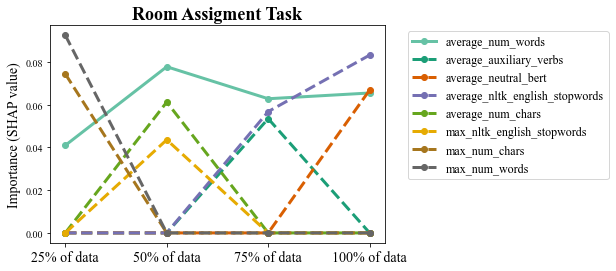

In [64]:
#csop_shap_means, csop_shap_cor_means, csop_train_means, csop_test_means
merged_df = pd.concat([csop_shap_means25, csop_shap_means50, csop_shap_means75, csop_shap_means], keys = time_points, axis=1)
plot_important_features_over_time(merged_df, "Room Assigment Task", "./figures/csop_features.svg")

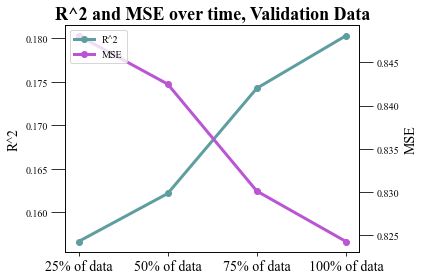

In [28]:
test_metrics = pd.concat([csop_test_means25, csop_test_means50, csop_test_means75, csop_test_means], keys = time_points, axis=1)
plot_r2_and_mse_over_time(test_metrics, "R^2 and MSE over time, Validation Data")

# DAT

### Full data (100%)

In [29]:
dat_model = ModelBuilder(dataset_names = ["dat"])
dat_model.select_target(target=["efficiency"])
dat_model.define_model(model_type = 'rf')

In [30]:
dat_shap, dat_shap_cor, dat_train_metrics, dat_test_metrics = repeated_kfold_cv(dat_model)
dat_shap_means, dat_shap_cor_means, dat_train_means, dat_test_means = get_repeated_kfold_cv_summary(dat_shap, dat_shap_cor, dat_train_metrics, dat_test_metrics)

Checking Holdout Sets...Creating Holdout Sets...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Done
Training Model...Done


### 75% Data

In [31]:
dat_model75 = ModelBuilder(dataset_names = ["dat"], output_dir = '../output/first_75/')
dat_model75.select_target(target=["efficiency"])
dat_model75.define_model(model_type = 'rf')

In [32]:
dat_shap75, dat_shap_cor75, dat_train_metrics75, dat_test_metrics75 = repeated_kfold_cv(dat_model75)
dat_shap_means75, dat_shap_cor_means75, dat_train_means75, dat_test_means75 = get_repeated_kfold_cv_summary(dat_shap75, dat_shap_cor75, dat_train_metrics75, dat_test_metrics75)

Checking Holdout Sets...Creating Holdout Sets...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Done
Training Model...Done


### 50% Data

In [33]:
dat_model50 = ModelBuilder(dataset_names = ["dat"], output_dir = '../output/first_50/')
dat_model50.select_target(target=["efficiency"])
dat_model50.define_model(model_type = 'rf')

In [34]:
dat_shap50, dat_shap_cor50, dat_train_metrics50, dat_test_metrics50 = repeated_kfold_cv(dat_model50)
dat_shap_means50, dat_shap_cor_means50, dat_train_means50, dat_test_means50 = get_repeated_kfold_cv_summary(dat_shap50, dat_shap_cor50, dat_train_metrics50, dat_test_metrics50)

Checking Holdout Sets...Creating Holdout Sets...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Done
Training Model...Done


### 25% Data

In [35]:
dat_model25 = ModelBuilder(dataset_names = ["dat"], output_dir = '../output/first_25/')
dat_model25.select_target(target=["efficiency"])
dat_model25.define_model(model_type = 'rf')

In [36]:
dat_shap25, dat_shap_cor25, dat_train_metrics25, dat_test_metrics25 = repeated_kfold_cv(dat_model25)
dat_shap_means25, dat_shap_cor_means25, dat_train_means25, dat_test_means25 = get_repeated_kfold_cv_summary(dat_shap25, dat_shap_cor25, dat_train_metrics25, dat_test_metrics25)

Checking Holdout Sets...Creating Holdout Sets...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Done
Training Model...Done


### Combine DAT Results

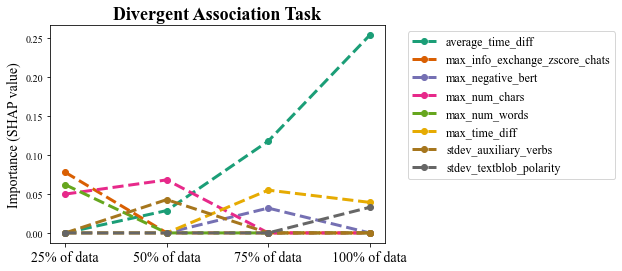

In [65]:
merged_df = pd.concat([dat_shap_means25, dat_shap_means50, dat_shap_means75, dat_shap_means], keys = time_points, axis=1)
plot_important_features_over_time(merged_df, "Divergent Association Task", "./figures/dat_features.svg")

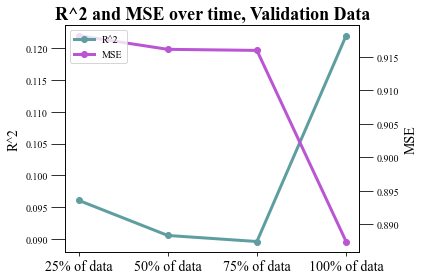

In [38]:
test_metrics = pd.concat([dat_test_means25, dat_test_means50, dat_test_means75, dat_test_means], keys = time_points, axis=1)
plot_r2_and_mse_over_time(test_metrics, "R^2 and MSE over time, Validation Data")

# Estimation

### Full Data (100%)

In [39]:
estimation_blended_model = ModelBuilder(dataset_names = ["gurcay", "becker"])
estimation_blended_model.select_target(target=["mean_post_discussion_error_pct", "mean_post_discussion_error_pct"])
estimation_blended_model.define_model(model_type = 'rf')

In [40]:
estimation_shap, estimation_shap_cor, estimation_train_metrics, estimation_test_metrics = repeated_kfold_cv(estimation_blended_model)
estimation_shap_means, estimation_shap_cor_means, estimation_train_means, estimation_test_means = get_repeated_kfold_cv_summary(estimation_shap, estimation_shap_cor, estimation_train_metrics, estimation_test_metrics)

Checking Holdout Sets...Creating Holdout Sets...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Done
Training Model...Done


### 75% Data

In [41]:
estimation_blended_model75 = ModelBuilder(dataset_names = ["gurcay", "becker"],  output_dir = '../output/first_75/')
estimation_blended_model75.select_target(target=["mean_post_discussion_error_pct", "mean_post_discussion_error_pct"])
estimation_blended_model75.define_model(model_type = 'rf')

In [42]:
estimation_shap75, estimation_shap_cor75, estimation_train_metrics75, estimation_test_metrics75 = repeated_kfold_cv(estimation_blended_model75)
estimation_shap_means75, estimation_shap_cor_means75, estimation_train_means75, estimation_test_means75 = get_repeated_kfold_cv_summary(estimation_shap75, estimation_shap_cor75, estimation_train_metrics75, estimation_test_metrics75)

Checking Holdout Sets...Creating Holdout Sets...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Done
Training Model...Done


### 50% Data

In [43]:
estimation_blended_model50 = ModelBuilder(dataset_names = ["gurcay", "becker"],  output_dir = '../output/first_50/')
estimation_blended_model50.select_target(target=["mean_post_discussion_error_pct", "mean_post_discussion_error_pct"])
estimation_blended_model50.define_model(model_type = 'rf')

In [44]:
estimation_shap50, estimation_shap_cor50, estimation_train_metrics50, estimation_test_metrics50 = repeated_kfold_cv(estimation_blended_model50)
estimation_shap_means50, estimation_shap_cor_means50, estimation_train_means50, estimation_test_means50 = get_repeated_kfold_cv_summary(estimation_shap50, estimation_shap_cor50, estimation_train_metrics50, estimation_test_metrics50)

Checking Holdout Sets...Creating Holdout Sets...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Done
Training Model...Done


### 25% Data

In [45]:
estimation_blended_model25 = ModelBuilder(dataset_names = ["gurcay", "becker"],  output_dir = '../output/first_25/')
estimation_blended_model25.select_target(target=["mean_post_discussion_error_pct", "mean_post_discussion_error_pct"])
estimation_blended_model25.define_model(model_type = 'rf')

In [46]:
estimation_shap25, estimation_shap_cor25, estimation_train_metrics25, estimation_test_metrics25 = repeated_kfold_cv(estimation_blended_model25)
estimation_shap_means25, estimation_shap_cor_means25, estimation_train_means25, estimation_test_means25 = get_repeated_kfold_cv_summary(estimation_shap25, estimation_shap_cor25, estimation_train_metrics25, estimation_test_metrics25)

Checking Holdout Sets...Creating Holdout Sets...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Done
Training Model...Done
Checking Holdout Sets...Creating Holdout Sets...
Done
Training Model...Done


### Combine Estimation Results

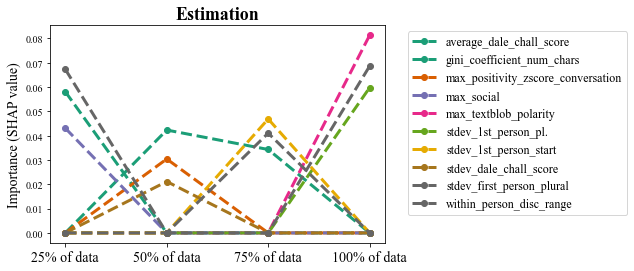

In [66]:
merged_df = pd.concat([estimation_shap_means25, estimation_shap_means50, estimation_shap_means75, estimation_shap_means], keys = time_points, axis=1)
plot_important_features_over_time(merged_df, "Estimation", "./figures/estimation_features.svg")

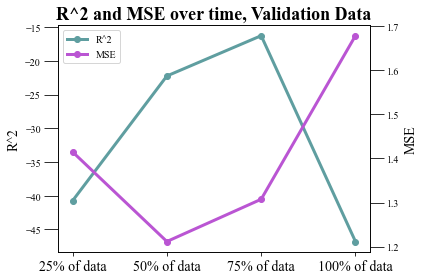

In [119]:
test_metrics = pd.concat([estimation_test_means25, estimation_test_means50, estimation_test_means75, estimation_test_means], keys = time_points, axis=1)
plot_r2_and_mse_over_time(test_metrics, "R^2 and MSE over time, Validation Data")

### Combine Metrics into Single Image

In [120]:
jury_metrics = pd.concat([jury_test_means25, jury_test_means50, jury_test_means75, jury_test_means], keys = time_points, axis=1) 
csop_metrics = pd.concat([csop_test_means25, csop_test_means50, csop_test_means75, csop_test_means], keys = time_points, axis=1)
dat_metrics = pd.concat([dat_test_means25, dat_test_means50, dat_test_means75, dat_test_means], keys = time_points, axis=1)
estimation_metrics = pd.concat([estimation_test_means25, estimation_test_means50, estimation_test_means75, estimation_test_means], keys = time_points, axis=1)

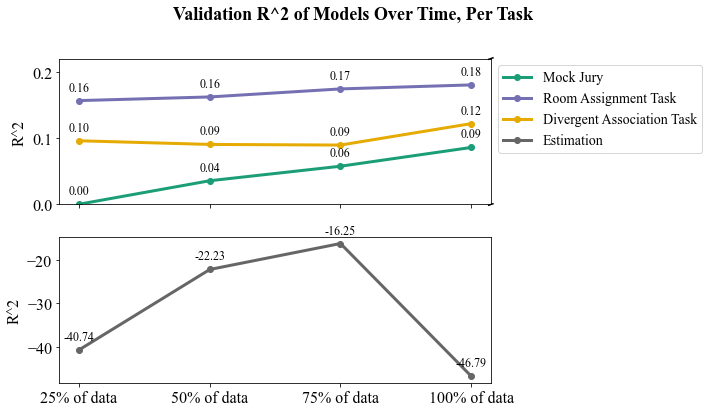

In [121]:
def plot_r2_with_broken_axis(datasets, dataset_names, title):
    fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(10, 6))

    plt.style.use({"figure.facecolor": "white", "axes.facecolor": "white"})

    # Define line styles and colors from Dark2 colormap
    num_colors = len(dataset_names)
    colors = mpl.cm.Dark2(np.linspace(0, 1, num_colors))

    # Plot datasets on ax1
    for i, dataset in enumerate(datasets):
        dataset_name = dataset_names[i]
        transposed_data = dataset.T

        # Create the left y-axis for R^2 on the first plot
        ax1.plot(time_points, transposed_data["r2"], marker='o', label=dataset_name, color=colors[i], linewidth=3)
        for x, y in zip(time_points, transposed_data["r2"]):
            ax1.annotate(f'{y:.2f}', (x, y), textcoords="offset points", xytext=(0,10), ha='center', fontsize=12)

    # Set limits for ax1
    ax1.set_ylim(0, 0.22)  # Adjust the limits as needed

    # Plot only "Estimation" dataset on ax2
    estimation_idx = dataset_names.index("Estimation")
    estimation_dataset = datasets[estimation_idx]
    estimation_name = dataset_names[estimation_idx]
    estimation_data = estimation_dataset.T

    ax2.plot(time_points, estimation_data["r2"], marker='o', label=estimation_name, color=colors[estimation_idx], linewidth=3)
    for x, y in zip(time_points, estimation_data["r2"]):
        ax2.annotate(f'{y:.2f}', (x, y), textcoords="offset points", xytext=(0,10), ha='center', fontsize=12)

    # Remove the space between the two plots
    plt.subplots_adjust(hspace=0)

    # Adjust layout and labels
    ax1.tick_params(axis="both", labelsize=16)  # Increase tick label size
    ax2.tick_params(axis="both", labelsize=16)  # Increase tick label size
    ax1.set_ylabel("R^2", fontsize=16)
    ax2.set_ylabel("R^2", fontsize=16)

    # Move the legend to the right for ax1
    lines, labels = ax1.get_legend_handles_labels()
    ax1.legend(lines, labels, loc="upper left", fontsize=14, bbox_to_anchor=(1, 1.005))  # Adjust the y-coordinate

    # Add broken y-axis symbol
    d = .005  # Offset for markings
    kwargs = dict(transform=ax1.transAxes, color='k', clip_on=False)
    ax1.plot((1-d,1+d), (-d,+d), **kwargs)
    ax1.plot((1-d,1+d),(1-d,1+d), **kwargs)

    # Adjust title position to the top
    plt.suptitle(title, fontweight="bold", fontsize=18)

    # Adjust layout
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.savefig('./figures/validation_test_r2_graph.svg', dpi=1200, bbox_inches='tight')
    plt.show()

# Assuming you have defined the four datasets and their names as you described
datasets = [jury_metrics, csop_metrics, dat_metrics, estimation_metrics]
dataset_names = ["Mock Jury", "Room Assignment Task", "Divergent Association Task", "Estimation"]

# # Call the function to plot R^2 values with broken y-axis
plot_r2_with_broken_axis(datasets, dataset_names, "Validation R^2 of Models Over Time, Per Task")


In [113]:
jury_metrics = pd.concat([jury_train_means25, jury_train_means50, jury_train_means75, jury_train_means], keys = time_points, axis=1) 
csop_metrics = pd.concat([csop_train_means25, csop_train_means50, csop_train_means75, csop_train_means], keys = time_points, axis=1)
dat_metrics = pd.concat([dat_train_means25, dat_train_means50, dat_train_means75, dat_train_means], keys = time_points, axis=1)
estimation_metrics = pd.concat([estimation_train_means25, estimation_train_means50, estimation_train_means75, estimation_train_means], keys = time_points, axis=1)

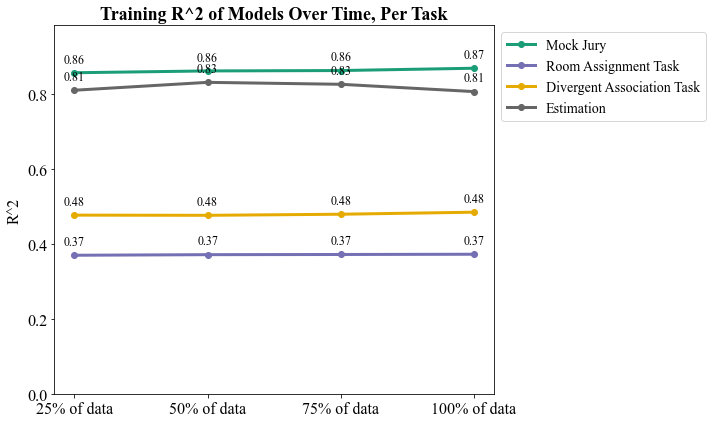

In [118]:
def plot_r2_without_broken_axis(datasets, dataset_names, title):
    fig, ax = plt.subplots(figsize=(10, 6))

    plt.style.use({"figure.facecolor": "white", "axes.facecolor": "white"})

    # Define line styles and colors from Dark2 colormap
    num_colors = len(dataset_names)
    colors = mpl.cm.Dark2(np.linspace(0, 1, num_colors))

    # Plot datasets on the same y-axis
    for i, dataset in enumerate(datasets):
        dataset_name = dataset_names[i]
        transposed_data = dataset.T

        # Plot R^2 values for each dataset
        ax.plot(time_points, transposed_data["r2"], marker='o', label=dataset_name, color=colors[i], linewidth=3)
        for x, y in zip(time_points, transposed_data["r2"]):
            ax.annotate(f'{y:.2f}', (x, y), textcoords="offset points", xytext=(0,10), ha='center', fontsize=12)

    # Adjust layout and labels
    ax.tick_params(axis="both", labelsize=16)  # Increase tick label size
    ax.set_ylabel("R^2", fontsize=16)

    # Add legend to the right
    lines, labels = ax.get_legend_handles_labels()
    ax.legend(lines, labels, loc="upper left", fontsize=14, bbox_to_anchor=(1, 1))

    # Set y-axis range with a buffer
    ax.set_ylim(0, max(ax.get_ylim()) * 1.1)

    # Adjust title position
    plt.title(title, fontweight="bold", fontsize=18)

    # Adjust layout
    plt.tight_layout()
    plt.savefig('./figures/train_r2_graph.svg', dpi=1200, bbox_inches='tight')
    plt.show()

# Assuming you have defined the four datasets and their names as you described
datasets = [jury_metrics, csop_metrics, dat_metrics, estimation_metrics]
dataset_names = ["Mock Jury", "Room Assignment Task", "Divergent Association Task", "Estimation"]

# Call the function to plot R^2 values without broken y-axis
plot_r2_without_broken_axis(datasets, dataset_names, "Training R^2 of Models Over Time, Per Task")
